In [1]:
# import itertools
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import h5py
import napari
import tifffile as tiff
import seaborn as sns
import pickle

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()
fig_dir = (Path().cwd().parents[0] / 'figure').absolute()

df_meta_path = data_dir / 'OCT Cell Culture' / 'Whole' / 'metadata' /  'imgs_reg_norm.csv'
df_imgs = pd.read_csv(df_meta_path)

# Viz images

In [5]:
def plot_spot_on_image(reference, spots, spacing, radius):
    spot_img = np.zeros_like(reference)
    coords = (spots[:, :3] / spacing).astype(int)
    r = radius  # shorthand
    for coord in coords:
        slc = tuple(slice(x-r, x+r) for x in coord)
        spot_img[slc] = 1
    return spot_img

In [6]:
df_imgs

,Timepoint,FOV,Path
0,HCC827Ctrl,FW1,Y:\coskun-lab\Thomas\15_PLA\data\OCT Cell Cult...
1,HCC827Ctrl,FW2,Y:\coskun-lab\Thomas\15_PLA\data\OCT Cell Cult...
2,HCC827Osim,FW1,Y:\coskun-lab\Thomas\15_PLA\data\OCT Cell Cult...
3,HCC827Osim,FW2,Y:\coskun-lab\Thomas\15_PLA\data\OCT Cell Cult...


In [7]:
path = df_imgs.iloc[0].Path

In [8]:
# with h5py.File(path, "r") as f:
#     imgs = f['imgs'][:]
#     markers = f['imgs'].attrs['Marker']

In [9]:
# napari.view_image(imgs, channel_axis=0, name=markers, visible=False, contrast_limits=[0,1])

# Viz PPI network

In [5]:
import networkx as nx

def read_pkl(path):
    with open(path, 'rb') as f:
        item = pickle.load(f)
    return item

def get_contours(contours, key, cell):
    contour_cell = contours[key]['Cell'][int(cell)]
    try:
        contour_nuclei = contours[key]['Nuclei'][int(cell)]
    except:
        contour_nuclei = None
    return contour_cell, contour_nuclei

def plot_network(g, label, ax, **kwargs):
    pos = nx.get_node_attributes(g, 'pos')
    pos_T = {k: v[[1,0]] for k,v in pos.items()}
    
    nx.draw(g, pos_T, node_color=label, with_labels=False, ax=ax, **kwargs)
    return ax
    
def plot_contour(contour_cell, contour_nuclei, ax, linewidth=2):
    contour = max(contour_cell, key = len)
    ax.plot(contour[:, 1], contour[:, 0], linewidth=linewidth, color='red')
    try:
        contour = max(contour_nuclei, key = len)
        ax.plot(contour[:, 1], contour[:, 0], linewidth=linewidth, color='blue')
    except:
        pass

In [6]:
from sklearn.preprocessing import OneHotEncoder
import matplotlib 
import scanpy

# Get encoder 
PPI_save_path =  data_dir / 'OCT Cell Culture' / 'Whole' / 'PPI'

# Read PPi info 
dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path)
        dfs.append(df)
df = pd.concat(dfs)

# Create label 
enc = OneHotEncoder(handle_unknown='ignore')
labels = enc.fit_transform(df['PPI'].to_numpy().reshape(-1, 1)).toarray().astype(np.uint8)
df['Labels'] = labels.tolist()
print(enc.categories_)
PPIs_name = enc.categories_[0]

# Define colormap
colors = [ '#ff00ff', '#00FF00', '#FF0000',  '#00FFFF', '#FFFF00']

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(PPIs_name, colors_rgb)}

[array(['CylinE & CDK2', 'Mcl-1 & BAK', 'P-ERK & c-MYC', 'TEAD1 & YAP1',
       'p-AKT & mTOR'], dtype=object)]


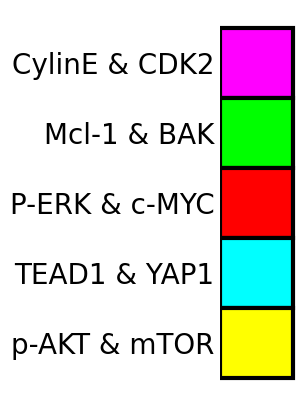

In [7]:
# legend
fig, ax = plt.subplots(figsize=(1,len(PPIs_name)))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=np.array(list(colors_rgb_dict.values()))/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )

_ = plt.yticks(range(len(colors_rgb_dict.values())), colors_rgb_dict.keys(), rotation=0, size=20)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)

In [13]:
import PLA

graph_save_path =  data_dir / 'OCT Cell Culture' / 'Whole' / 'graphs' / 'raw'
contour_save_path =  data_dir / 'OCT Cell Culture' / 'Whole' / 'contours'

cell_data = PLA.cell_data(contour_save_path, graph_save_path)

Loading graphs
Loading contours


In [14]:
# Check if graph connected
df_subset = cell_data.df.sample(100)
for i in range(len(df_subset)):
    # Info
    row = df_subset.iloc[i]
    key = '_'.join(row.iloc[:2])
    
    cell = row.iloc[2]
    
    # Get graph
    network = read_pkl(row.Path)
    
    if not nx.is_connected(network):
        print(row)
        
# Print existing node attributes in graph
node_attr = {k for attr_dict in network.nodes.data()._nodes.values() for k in attr_dict.keys()}
print(node_attr)

{'labels', 'pos', 'nuclei'}


In [15]:
# df_subset = cell_data.df.sample(10, random_state=0)

# for i in range(len(df_subset)):
#     # Info
#     row = df_subset.iloc[i]
#     key = '_'.join(row.iloc[:2])
#     cell = row.iloc[2]
    
#     # Get graph
#     network = read_pkl(row.Path)
#     network.remove_edges_from(list(nx.selfloop_edges(network)))
    
#     nuclei = list(nx.get_node_attributes(network, 'nuclei').values())
#     labels = list(nx.get_node_attributes(network, 'labels').values())
#     labels = np.argmax(labels, axis=1)
#     node_colors = [colors_rgb_dict[PPIs_name[i]]/255 for i in labels]

#     # Get contours
#     contour_cell, contour_nuclei = get_contours(cell_data.contours, key, cell)
    
#     # Plot
#     f, axs = plt.subplots(1, 2, figsize=(8,4))
#     ax = axs[0]
#     ax = plot_network(network,  nuclei, ax, node_size=40, cmap='jet', edgecolors='k')
#     plot_contour(contour_cell, contour_nuclei, ax)
#     ax = axs[1]
#     ax = plot_network(network,  node_colors , ax, node_size=40, edgecolors='k')
#     plot_contour(contour_cell, None, ax, linewidth=1)
#     axs[0].invert_yaxis()
#     axs[1].invert_yaxis()
#     plt.show()
#     break

# Plot Whole FOV PPI network

In [19]:
group = cell_data.df.groupby(['Condition', 'FOV'])

In [66]:
fig_path = fig_dir / 'PPI' / 'OCT Cell Culture' / 'Whole' / 'FOV'
fig_path.mkdir(parents=True, exist_ok=True)

In [67]:
# # Loop through Condition FOV
# for name, df_group in group:
#     # Get imgs shape 
#     path = df_imgs[(df_imgs.Timepoint == name[0]) & (df_imgs.FOV == name[1])].Path.item()
#     with h5py.File(path, "r") as f:
#         img_shape = f['imgs'].shape[1:]
    
#     img_fov = np.zeros(img_shape)
    
#     fig, ax = plt.subplots(figsize=(20,10))
#     ax.imshow(img_fov, cmap='gray', vmin=0, vmax=255)
#     ax.axis('off')
#     ax.set_facecolor('k')

#     # Get Individual cell
#     for row in df_group.itertuples():
#         key = '_'.join(row[1:3])
#         cell = row[3]
#         # Get contours
#         contour_cell, contour_nuclei = get_contours(cell_data.contours, key, cell)
#         contour = max(contour_cell, key = len)
        
#         # Plot contours
#         plot_contour(contour_cell, contour_nuclei, ax, linewidth=0.5)
        
#         # Get graph
#         network = read_pkl(row.Path)
#         network.remove_edges_from(list(nx.selfloop_edges(network)))

#         nuclei = list(nx.get_node_attributes(network, 'nuclei').values())
#         labels = list(nx.get_node_attributes(network, 'labels').values())
#         labels = np.argmax(labels, axis=1)
#         node_colors = [colors_rgb_dict[PPIs_name[i]]/255 for i in labels]
        
#         # Plot network
#         plot_network(network,  node_colors, ax, node_size=2, linewidths=0, edgecolors='w', width=0.3, edge_color='w')
    
#     file_name = '_'.join(name)
#     fig.savefig(fig_path / f'{file_name}.png', dpi=800, transparent=True, bbox_inches='tight', pad_inches=0)
#     plt.close()


# Plot with visual examples

In [8]:
from skimage.morphology import white_tophat as skimage_white_tophat
from copy import deepcopy

# Read images
def read_img_bbox(path, bbox, pad = 20):
    min_y, min_x, max_y, max_x = bbox
    min_y = np.clip(min_y - pad, a_min=0, a_max=None)
    min_x = np.clip(min_x - pad, a_min=0, a_max=None)
    max_y += pad
    max_x += pad
    
    with h5py.File(path, "r") as f:
        markers = f['imgs'].attrs['Marker']
        imgs = f['imgs'][..., min_y:max_y, min_x:max_x]
    
    return imgs, markers

def white_tophat(image, radius):
        # ensure iterable radius
        if not isinstance(radius, (tuple, list, np.ndarray)):
            radius = (radius,)*image.ndim

        # convert to footprint shape
        shape = [2*r+1 for r in radius]

        # run white tophat
        return skimage_white_tophat(image, footprint=np.ones(shape))
    
    
def plot_contour_mean(contour_cell, contour_nuclei, offset, ax, linewidth=1):
    contour = deepcopy(max(contour_cell, key = len))
    contour -= np.array(offset)
    ax.plot(contour[:, 1], contour[:, 0], linewidth=linewidth, color='red')
    try:
        contour = deepcopy(max(contour_nuclei, key = len))
        contour -= np.array(offset)
        ax.plot(contour[:, 1], contour[:, 0], linewidth=linewidth, color='blue')
    except:
        pass
    
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

blue = LinearSegmentedColormap.from_list(
        "Blue", [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 1.0, 1.0]])

def plot_PPI(imgs, markers, contour_cell, contour_nuclei, offset, ax, 
             colors_rgb_dict=colors_rgb_dict, 
             q_min=0.8,
             q_max=0.999,
             subset=['Hoeschst', 'TEAD1 & YAP1', 'CylinE & CDK2', 'P-ERK & c-MYC', 'p-AKT & mTOR', 'Mcl-1 & BAK']):
    for i in range(len(subset)):
        indice = list(markers).index(subset[i])
        if i == 0:
            ax.imshow(imgs[indice], vmin=0, vmax=1.0, cmap=blue)
        else:
            # Get custom colormap 
            c_cmap = LinearSegmentedColormap.from_list("Blue", 
                                            [[0.0, 0.0, 0.0, 0.0], 
                                             np.array(list(colors_rgb_dict[subset[i]])+[255])/255])
            ax.imshow(imgs[indice], vmin=np.quantile(imgs[indice], q_min), 
                      vmax=np.quantile(imgs[indice], q_max), 
                      cmap=c_cmap)
        ax.axis('off')
        if contour_cell is not None:
            plot_contour_mean(contour_cell, contour_nuclei, offset, ax)

In [10]:
fig_path = fig_dir / 'PPI' / 'OCT Cell Culture' / 'Whole' / 'Cell'
fig_path.mkdir(parents=True, exist_ok=True)    

# subset = ['Hoeschst',  'Ki67', 'Tom20', 'Pan-cytokeratin', 'p-EGFR', 'Golph4']
subset = ['Hoeschst',  'p-EGFR']
colors_rgb_dict_protein = {k:v for k,v in zip(subset[1:], colors_rgb_dict.values())}

In [17]:
df_subset = cell_data.df

pad = 5
for i in range(len(df_subset)):
    # Info
    row = df_subset.iloc[i]
    key = '_'.join(row.iloc[:2])
    cell = row.iloc[2]
    
    file_name = '_'.join([key, cell])
    if (fig_path / f'{file_name}.png').exists():
        continue
        
    # Get image path
    img_path = df_imgs[(df_imgs.FOV == row.FOV) & (df_imgs.Timepoint == row.Condition)].Path.item()
    
    # Get contours
    contour_cell, contour_nuclei = get_contours(cell_data.contours, key, cell)
    contour = max(contour_cell, key = len)
    max_y, max_x = contour.max(axis=0).astype(int)
    min_y, min_x = contour.min(axis=0).astype(int)
    
    # Get mutiplex images
    img, markers = read_img_bbox(img_path, [min_y, min_x, max_y, max_x], pad=pad)
    img = white_tophat(img, 3)
    
    # Get graph
    network = read_pkl(row.Path)
    network.remove_edges_from(list(nx.selfloop_edges(network)))
    
    nuclei = list(nx.get_node_attributes(network, 'nuclei').values())
    labels = list(nx.get_node_attributes(network, 'labels').values())
    labels = np.argmax(labels, axis=1)
    node_colors = [colors_rgb_dict[PPIs_name[i]]/255 for i in labels]
    
    with plt.style.context('dark_background'):
        
        # Plot Graph
        f, axs = plt.subplots(1, 3, figsize=(12,4), facecolor='k')
        ax = axs[0]
        plot_network(network,  node_colors, ax, node_size=60, edgecolors='w', width=1.5, edge_color='w')
        plot_contour(contour_cell, contour_nuclei, ax, linewidth=1)
        ax.set_facecolor('k')

        ax=axs[1]
        ax.set_facecolor('k')
        plot_PPI(img, markers, contour_cell, contour_nuclei, offset=[min_y-pad, min_x-pad], ax=ax)
        
        ax=axs[2]
        ax.set_facecolor('k')
        plot_PPI(img, markers, None, None, offset=[min_y-pad, min_x-pad], colors_rgb_dict=colors_rgb_dict_protein,
                 subset = subset,
                 q_min=0.02,
                 q_max=0.99,
                 ax=ax)

        axs[0].invert_yaxis()
        axs[0].set_aspect('equal')
        f.set_facecolor("#00000F")
        f.subplots_adjust(wspace=0.01)
        f.suptitle(f'{key}_{cell}', fontsize=16, color='w')
        
        file_name = '_'.join([key, cell])
        f.savefig(fig_path / f'{file_name}.png', dpi=800, transparent=True, bbox_inches='tight', pad_inches=0)
        plt.close()

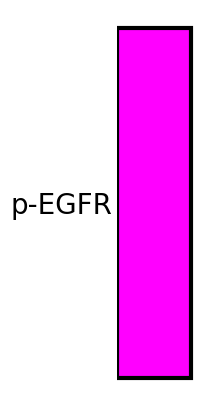

In [11]:
# legend
fig, ax = plt.subplots(figsize=(1,len(PPIs_name)))
ax.barh(y=range(len(colors_rgb_dict_protein.values())), 
        color=np.array(list(colors_rgb_dict_protein.values()))/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )

_ = plt.yticks(range(len(colors_rgb_dict_protein.values())), colors_rgb_dict_protein.keys(), rotation=0, size=20)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)

In [ ]:
# import napari

# napari.view_image(img, channel_axis=0, name=markers, visible=False)

# Coexpression 

In [12]:
import numpy as np
from scipy import stats
import matplotlib 

def create_HM(
    df_per_label, my_cmap, scale_name, cellSizePixels=25, **kwargs
):
    # Calulate the figure size, this gets us close, but not quite to the right place
    dpi = matplotlib.rcParams["figure.dpi"]
    marginWidth = (
        matplotlib.rcParams["figure.subplot.right"]
        - matplotlib.rcParams["figure.subplot.left"]
    )
    marginHeight = (
        matplotlib.rcParams["figure.subplot.top"]
        - matplotlib.rcParams["figure.subplot.bottom"]
    )
    Ny, Nx = df_per_label.shape
    figWidth = (Nx * cellSizePixels / dpi) / marginWidth
    figHeigh = (Ny * cellSizePixels / dpi) / marginHeight

    ax = sns.clustermap(
        df_per_label,
        cbar_kws={"fraction": 0.01},
        cmap=my_cmap,
        linewidth=0.1,
        dendrogram_ratio=(0.1, 0.1),
        figsize=(figWidth, figHeigh),
        **kwargs,
    )
    ax.ax_heatmap.set_yticklabels(ax.ax_heatmap.get_yticklabels(), rotation=0)
    ax.ax_heatmap.set_xticklabels(
        ax.ax_heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
    )
    ax.ax_heatmap.set_xlabel("Marker")
    ax.ax_heatmap.set_ylabel("Marker")

    # calculate the size of the heatmap axes
    axWidth = (Nx * cellSizePixels) / (figWidth * dpi)
    axHeight = (Ny * cellSizePixels) / (figHeigh * dpi)

    # resize heatmap
    ax_heatmap_orig_pos = ax.ax_heatmap.get_position()
    ax.ax_heatmap.set_position(
        [ax_heatmap_orig_pos.x0, ax_heatmap_orig_pos.y0, axWidth, axHeight]
    )

    # resize dendrograms to match
    ax_row_orig_pos = ax.ax_row_dendrogram.get_position()
    ax.ax_row_dendrogram.set_position(
        [ax_row_orig_pos.x0, ax_row_orig_pos.y0, ax_row_orig_pos.width, axHeight]
    )
    ax_col_orig_pos = ax.ax_col_dendrogram.get_position()
    ax.ax_col_dendrogram.set_position([ax_col_orig_pos.x0, ax_heatmap_orig_pos.y0+axHeight,
                                         axWidth, ax_col_orig_pos.height])

    # Change colorbar label position
    cbar = ax.ax_heatmap.collections[0].colorbar
    cbar.set_label(scale_name, fontsize=12)
    
    pos = ax.ax_heatmap.get_position()
    cbar_size=0.6
    ax.ax_cbar.set_position((1.8, pos.y0, .03, cbar_size))

    for _, spine in ax.ax_heatmap.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(3)

def generate_correlation_map(x, y):
    corr = np.empty((len(x), len(y)))
    p_val = np.empty((len(x), len(y)))
    for n in range(x.shape[0]):
        for m in range(y.shape[0]):
            result = stats.pearsonr(x[n, :], y[m, :])
            corr[n, m] = result[0]
            p_val[n, m] = result[1]
    return corr, p_val

In [13]:
# Read PPI expression data
PPI_save_path =  data_dir / 'OCT Cell Culture' / 'Whole' / 'PPI' / 'expression'

dfs = []
for path in os.listdir(PPI_save_path):
    if 'csv' in path:
        df = pd.read_csv(PPI_save_path / path, index_col=0)
        dfs.append(df)

df_exp = pd.concat(dfs)

df_exp.drop(['Phalloidin', 'Golph4', 'NBD-C6', 'COX IV'], axis=1, inplace=True)

# Check for general trend y converting to adata and groupby by Condition
df_obs = df_exp.iloc[:, :8]
df_marker_exp = df_exp.iloc[:, 8:]
# df_norm = (df_marker_exp-df_marker_exp.min())/(df_marker_exp.max()-df_marker_exp.min())
# df_norm = (df_marker_exp - df_marker_exp.mean())/df_marker_exp.std()
df_norm = (df_marker_exp-df_marker_exp.quantile(0.05))/(df_marker_exp.quantile(0.95)-df_marker_exp.quantile(0.05))
df_norm = df_norm.clip(lower=0, upper=1)
df_exp.iloc[:, 8:] = df_norm


In [14]:
label = 'PPI'
PPI_names = ['TEAD1 & YAP1', 'CylinE & CDK2', 'P-ERK & c-MYC', 'p-AKT & mTOR', 'Mcl-1 & BAK']
# protein_marker_names = ['p-EGFR', 'Tom20', 'Pan-cytokeratin', 'Golph4', 'Ki67', 'NBD-C6', 'COX IV','Concanavalin A', 'WGA']
protein_marker_names = ['p-EGFR', 'Tom20', 'Pan-cytokeratin', 'Ki67', 'Concanavalin A', 'WGA']

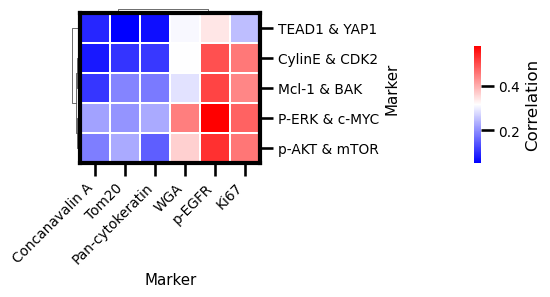

In [15]:
x = df_exp[PPI_names].values.T
y = df_exp[protein_marker_names].values.T

# Get correlation
corr, p_val = generate_correlation_map(x, y)

# Import into dataframe
df_corr = pd.DataFrame(corr, index=PPI_names, columns=protein_marker_names, )

with sns.plotting_context('talk', font_scale=0.6):
    create_HM(df_corr, 'bwr', 'Correlation', cellSizePixels=30)

C:\Users\thu71\AppData\Local\Temp\ipykernel_27200\4239256979.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, df_group in group:


HCC827Ctrl
HCC827Osim


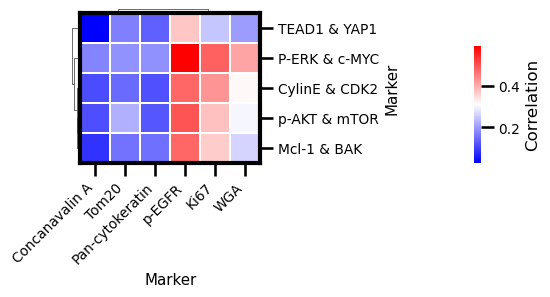

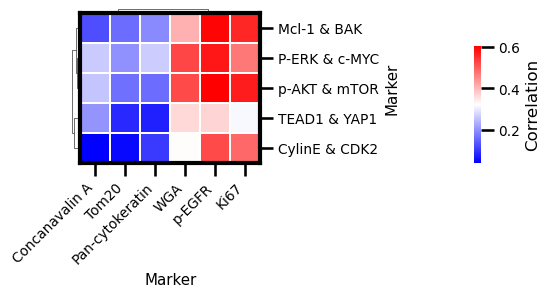

In [16]:
group = df_exp.groupby(['Condition'])
for name, df_group in group:
    print(name)
    x = df_group[PPI_names].values.T
    y = df_group[protein_marker_names].values.T
    
    # Get correlation
    corr, p_val = generate_correlation_map(x, y)
    
    # Import into dataframe
    df_corr = pd.DataFrame(corr, index=PPI_names, columns=protein_marker_names)
    
    # Create HM
    with sns.plotting_context('talk', font_scale=0.6):
        create_HM(df_corr, 'bwr', 'Correlation', cellSizePixels=30)
    

In [ ]:
def plot_spot_on_image(reference, spots, spacing, radius):
        spot_img = np.zeros_like(reference)
        coords = (spots[:, :3] / spacing).astype(int)
        r = radius  # shorthand
        for coord in coords:
            slc = tuple(slice(x-r, x+r) for x in coord)
            spot_img[slc] = 1
        return spot_img